## Abstract

Higher Education Institutions (HEI) have a vested interest in ensuring that students are successful in their studies.  The motivation is multi-faceted – by ensuring positive student experience and good student outcomes, HEIs reap the benefits of an enhanced reputation, improved metrics affecting league table placement and more stable student numbers.  HEIs are subsequently able to attract and retain more students and further improve their educational services.

Learner Analytics is a field of research which can support students and HEIs by improving student experience, enriching learning and teaching, identifying at-risk students, and bettering retention and progression.

This exploratory report investigates several predictive learning algorithms trained on student engagement data to predict multiclass and binary outcomes.  It is proof-of-concept in nature, exploring the viability and generalisability of learning algorithms on engagement behaviour during a course.  It compares several models and briefly discusses the results in the context of the HEI.

Word count: 2050


## Introduction

Higher Education Institutions (HEIs) are complex organisations offering educational services to a diverse student body.  HEIs have students' learning success at heart but they must also operate as viable businesses.  

An HEI's success is measured by its students' success - good outcomes for students equate with improved student recruitment, continuation and retention, enhanced reputation and financial stability.

`Learner Analytics` is a growing field of research in Higher Education (HE).  HEIs are increasingly using data to inform decision-making and improve student experience.  In a sector report from 2017, it was found that HEIs "working towards [learner analytics systems] implementation has nearly doubled from 34% to 66%" and that the focus has shifted "towards retention more than learning" (17% to 37%) (Newland, 2017).

This report evaluates the performance of several learning algorithms in predicting student outcome using 'student engagement' data.  It explores the opportunity for early intervention in the the case of students who are predicted to fail or withdraw.  


## Data

[Open University](https://www.open.ac.uk/about/main/) is one of the world's largest distance learning providers, with over 200,000 students (Wikipedia, 2023.).  All of its teaching takes place in virtual learning environments (VLEs).  


### Dataset

The [Open University Learning Analytics Dataset (OULAD)](https://analyse.kmi.open.ac.uk/open_dataset) contains data about courses, students and their Virtual Learning Environment (VLE) interactions. It consists of tables connected using unique identifiers:


![OULAD data model](../_images/OU_data_model.png)

The dataset is rich, containing student biographic and demographic characteristics, including gender, age, disability status, educational background, IMD band[^1], and region.  In addition to person details, it has students' academic history, assessments and VLE interactions[^2] (Kuzilek, et al, 2017). 

It includes February and October registrations across two academic years (2013 and 2014).  There are 32,593 student registrations (28,785 unique students) - 13,529 are active in 2013 and 19,064 in 2014.  

Assessment data includes assessment type, date, weight and score.  VLE data includes type of count of interactions, date and time.

[^1]: IMD is the `Index of Multiple Deprivation` which is a standard measure of relative deprivation of the student using multiple variables. (Gov.uk, 2019)
[^2]: Additional details about OULAD preparation can be found here - [https://www.nature.com/articles/sdata2017171#Sec2](https://www.nature.com/articles/sdata2017171#Sec2)

### Exploratory Data Analysis

Following initial data processing, the dataset contains 31437 rows and 27 *potential* features.[^3] - 46.6% of students passed, 31.4% withdrew and 22.0% failed.

![Overall outcome distribution](../_images/EDA_Distribution_by_Outcome.png)

A selection of findings are presented below.

#### Students

These are the distributions of outcomes by gender (M/F) and disability status (Y/N): 

![Distribution by gender, disability](../_images/EDA_Distribution_by_gender_disability.png)

`Chi-square` tests of independence indicate that there is a statistically significant ($p<0.05$) association between both gender (moderate) and disability status (high) and final_outcome.[^4]  This was also the case when looking at a binary outcome of 'intervention' (fail or withdraw) vs 'no intervention' (pass or distinction).[^5]

`Chi-square` tests for the other student characteristics (age_band, region, highest_education, imd_band) also suggest statistically significant ($p<0.05$) associations with final_outcome.  The plots below show clear differences between groups in terms of outcomes, for example, students with lower 'highest_eduction' have higher withdrawal rates, perhaps because they are less accustomed to the academic environment.  It is also notable that students have more success (pass, distinction) in the older age bands. As IMD_band increases, the number of withdrawn and fail students decline and students who pass with distinction increase

![Distribution by Age, IMD, Education, Region](../_images/EDA_Distribution_by_age_imd_edu_reg.png)

#### Curriculum

There are seven modules across two subjects - `STEM` and `Social Sciences`; `STEM` students are more likely to withdraw.  There are more students in 2014.

![outcome_year_subject](../_images/EDA_outcome_year_subject.png)

Average assessment scores vary between modules.  If a student's subject or intake *potentially* affects their outcome, this might have merit as a predictive feature.

![score_by_module](../_images/EDA_assessment_by_code.png)

#### Academic / Engagement

The main goal of this report is to evaluate a generalised model predicting outcome from *engagement behaviour* - that is, excluding student person and curriculum features.  Thus, models are built with below features.

Boxplots of engagement behaviour show clear association between features and the outcome.  Students who have higher average scores, click more and spend more days using the VLE have a higher likelihood of passing.  

![outcome_by_age](../_images/EDA_outcome_by_engage.png)

`Kruskal-Wallis` test was used to statistically compare distributions of continuous variables.  They are all statistically significant ($p<0.05$); the null-hypothesis, that the differences between outcomes are due to chance alone, is rejected in favour of the alternative.[^6]  

This is a good indication that these features will be useful.

#### Dates

Students withdraw throughout their course.  

There are two spikes towards the beginning of the course - on day 0 and a few weeks into the course.  There may be too little engagement data to confidently predict these outcomes, but a different research question may involve using other data and techniques to predict early withdrawals.  

Students who did not start the course are not included in the dataset.

![withdrawals_over_time](../_images/EDA_withdrawals.png)

There is a steady stream of withdrawals throughout the course.  The cumulative withdrawal plot shows that approximately 50% of students withdraw by day 100 - if these students can be identified with precision, there may be opportunities to affect outcome.

[^3]: If interested in more EDA: [Additional EDA](../code/V2/02_EDA.ipynb)
[^4]: Gender: Chi-square statistic: 24.208, p-value: 2.260e-05
Disability: Chi-square statistic: 128.412, p-value: 1.189e-27
[^5]: Gender: Chi-square statistic: 24.018, p-value: 9.543e-07
Disability: Chi-square statistic: 104.779, p-value: 1.365e-24
[^6]: Average score: Kruskal-Wallis statistic: 22898.85, p-value: 0.0
Submission distance: Kruskal-Wallis statistic: 1745.16, p-value: 0.0
Total clicks: Kruskal-Wallis statistic: 14263.82, p-value: 0.0
Days active: Kruskal-Wallis statistic: 16091.56, p-value: 0.0



### Data Preparation for Modeling

#### Splitting

Several approaches to splitting the data for training was considered:

* by year - train on 2013 and predict on 2014
* by module - train and predict on each module separately
* complete - train and test datasets from complete dataset

As the 2013 and 2014 subsets are different, models were trained on a subset of the complete dataset, split with stratification.  This was to ensure that the training data contained examples of each module and presentation combination.[^7]

* training - 60%
* validation - 20%
* test - 20% - unseen until final model

In the real-world, theses models *would* predict `2015` students. 

#### Feature Selection and Engineering

As the scenario is to predict outcome from engagement, all student features were removed from the dataset[^8] to focus on engagement and assessment as predictors.

Data was cleaned to remove or impute missing values as per dataset author notes. (Kuzilek, et al, 2017)

Features were engineered from the original dataset:

Numerical features (scaled):

  * number_of_previous_attempts
  * studied_credits
  * proportion_submissions
  * average_score
  * submission_distance
  * activity_count
  * total_clicks
  * days_active

Categorical features (one-hot encoded):

* subject

The target is: `final_result`

Models predicting multivariate outcome ('Pass', 'Distinction', 'Withdrawn', 'Fail') were compared with binary classifiers ('intervention' (fail or withdraw) vs 'no intervention' (pass or distinction)).

#### Dimensionality Reduction

`Principal Component Analysis` as a dimensionality reduction technique was explored but ultimately not pursued - the results were similar with or without PCA transformation.[^9]

[^7]: Modules CCC is only represented in 2014 and modules EEE and GGG are only represented in October 2013.
[^8]: Additional information on feature selection can be found here: [Features](/code/V2/03_Features.ipynb)
[^9]: For more detail on PCA exploration, please visit: [Dimension Reduction - PCA](/code/V2/04_2_model_reduce.ipynb)




## Analysis Type

This is a multivariate binary classification problem.  HEIs want to predict students who are likely to discontinue their studies as early as possible using available engagement data. The analysis is multivariate since it considers multiple engagement features simultaneously to predict the outcome.  This allows the model to detect complex interactions and dependencies between features and the outcome.  For example, students who engage on more days and have higher average scores may be less likely to need intervention.

Predicting multiclass outcome (pass, distinction, fail, withdraw) may have other use-cases but the primary HEI goal is to address non-continuation.

## Learning Algorithms

### Selection

Several models where considered for evaluation: 

* **Logistic Regression** - LR is easy to interpret with optional probabilistic output.  LRs assume a linear relationship between features and target.  It is less prone to overfitting.
* **Decision Tree** - DTs are simple but prone to overfitting and sensitive to small variations in the data; therefore they may create overly-complex trees which do not generalise well.
* **Random Forest** - RFs are robust to outliers, noisy data, high-dimensionality and non-linear relationships.
* **Support Vector Classifier** - SVCs are good for high-dimensional feature spaces, handle linear and non-linear relationships and are robust to outliers.  They can be computationally expensive.
* **K-Nearest Neighbours** - KNNs are easy to interpret but computationally expensive and sensitive to k neighours.

All models are suitable for both categorical and numerical features.
  
A less suitable model was explored - Gaussian Naive Bayes.  GNB assumes independence between features and can struggle with imbalanced datasets.  This dataset suffers both - there are less well-represented groups and features are not independent as they have been engineered from the same underlying data. 

The highly-correlated features on the bottom right corner are those included in the model.

![selected_correlation](../_images/correlation_heat.png)




### Evaluation Metrics

To evaluate the binary classification models, the following metrics are considered: 

* **Accuracy** - proportion of correct predictions: 

    $(TruePositive + TrueNegative) / (TruePositive + TrueNegative + FalsePositive + FalseNegative)$

Accuracy is the most common evaluation metric, but it is less suitable for imbalanced datasets.  

* **Precision** - proportion of correctly predicted positive instances out of all predicted positive instances:

    $TruePositive / (TruePositive + FalsePositive)$

Precision is useful when the cost of false positives (misclassifying a student as needing intervention when they do not) is high.  

* **Recall** - proportion of correctly predicted positive instances out of all actual positive instances:

    $TruePositive / (TruePositive + FalseNegative)$

Recall is particularly useful when the cost of false negatives (misclassifying a student as not needing intervention when they do) is high.  This might be a metric for HEIs to consider.

* **F1 Score** - the harmonic mean of precision and recall:

    $2 * (Precision * Recall) / (Precision + Recall)$

F1 score balances precision and recall and is useful when there is an uneven class distribution or when both metrics are important. 

The trained models were optimised using `accuracy` due to its ubiquity.  Whilst important, `precision` and `recall` are better considered with more developed models and HEI requirements.

## Models - Results and Interpretation

### Initial Results

'PCA-transformed' and 'non-PCA' datasets are compared across all evaluation metrics.  There is very little difference between datasets, all else equal:

![output_binary](../_images/result_binary.png)

The best performing model was the `Random Forest` model on the non-PCA dataset with an accuracy of 0.93.[^10]

[^10] For reference, the best accuracy for the multivariate outcome was 0.71 for the `Random Forest` model. 



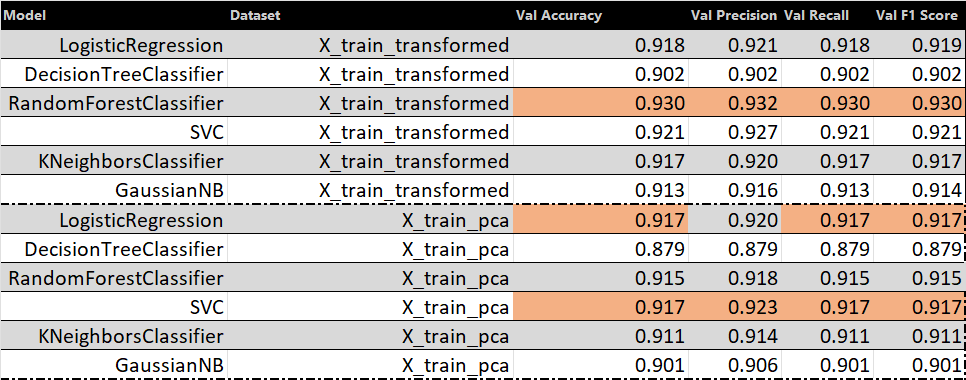



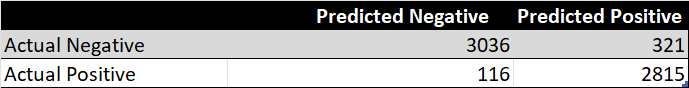


In the above confusion matrix, the 'actual positives' are students who do not require intervention (passed, distinction) and 'actual negatives' are students who do may benefit from intervention (withdrawn, fail).  

The model correctly identified 3036 students who may have benefited from intervention and failed to predict intervention for 321 students who went on to fail or withdraw.  It incorrectlly predicted that 116 students should have intervention when in actual fact they passed.

### Tuned Results

#### Hyperparameter Tuning

The `non-PCA` data was used to optimise the models using `GridSearchCV` to find the best combination of hyperparameters.[^10]

The models were improved by 0-2% with the best performing model still being the Random Forest model with an accuracy of 0.932


['LR', 'DT', 'RF', 'SVC', 'KNN', 'GNB']
{'LR': LogisticRegression(C=10.0, max_iter=10000), 'DT': DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10), 'RF': RandomForestClassifier(min_samples_split=5, n_estimators=200), 'SVC': SVC(C=10.0), 'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=7), 'GNB': GaussianNB()}
[0.9185750636132316, 0.9223918575063613, 0.931615776081425, 0.9243002544529262, 0.9225508905852418, 0.9134860050890585]

[^10]: 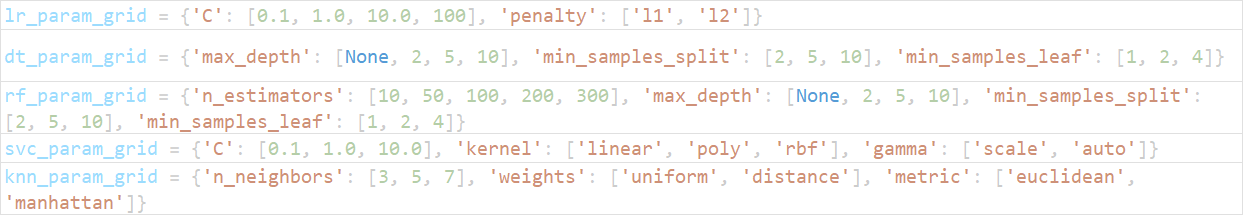

#### Ensemble Modelling

For the sake of completeness, an ensemble model was created using the best performing models for each outcome.  The model was created using the `VotingClassifier` with the following models:

* Random Forest
* Logistic Regression
* Support Vector Classifier
* K-Nearest Neighbours
* Gaussian Naive Bayes
* Decision Tree

The model performed similarly to the Random Forest model with an accuracy of 0.926.  

A stacking model was also created using the `StackingClassifier` with the same models.  It was fractionally behind the Random Forest model with an accuracy of 0.932.

## Limitations / Future Considerations

### Conclusion

This project is an initial exploration of a very rich learning analytics dataset.  It is a proof-of-concept demonstrating the potential of using 'engagement data' to predict student outcomes.  

It should be noted that:

* HEIs with face-to-face teaching may have different engagement patterns, datasets and outcomes.
* models do not consider student demographics, etc.  
* models do not explicitly consider differences between modules, presentations, etc.

In addition to the above, there is much potential for further research:

* temporal nature of the data - for example, the number of days between engagements, the time of day, etc.
* impact of VLE and/or assessment type.
* student profiles using unsupervised learning techniques.
* impact of new/more data
* model performance on substantial changes to behaviour - e.g. student behaviour pre and post COVID-19?
* impact of missing data
* generalised models v module-specific models
* real-time model improvement with data feed loops
* interventions as a feature
* impact of interventions



### Final Assessment

In the real-world, HEIs would only be able to predict using existing data up to the prediction point.  A mechanism to prepare data based on a `prediction_point` was developed - assessments and VLE engagements after the prediction point are removed as well as students who have already withdrawn, as their outcome is known.  

The data changes in multiple ways:

* the number of students reduces moving away from course start (withdrawn students removed)
* engagement and assessment values are changed (interactions yet-to-take-place are removed)
* where no engagement or assessment (but student is not withdrawn), the value is set to 0

Predicting on *completely unseen* `test` data (prepared for 50, 100, 150 days after course start) using the best model (Random Forest) produced favourable results, suggesting the identification of students for early intervention is possible with assessment and VLE engagement data, achieving accuracies of around 97%.  

![final_model](../_images/final_model.png)


## Bibliography